In [40]:
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,scale,StandardScaler,RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from tqdm.notebook import tqdm  # Import tqdm for progress bar
import seaborn as sns
from myMLlib import set_seed, load_feather, rebalance_weight, plt_loss, plt_confusion, layer_activation, multi_SA_memwise
from scipy.sparse.linalg import svds
from torch.utils.data import TensorDataset, DataLoader
import yaml

In [41]:
with open('hyperparameters.yml', 'r') as file:
    all_parameters = yaml.safe_load(file)
    parameters = all_parameters['real-blood-meat-time']
materials = parameters['materials']
realmater = parameters['realmater']
materials = list(materials.values())
print(materials)
print(realmater)


['Vessel', 'Tissue']
['Silicone/Water', 'Silicone']


In [42]:
folderpath= ('/home/yuqster/files/research/dataset/realtest1',
             '/home/yuqster/files/research/dataset/realtest2',
             '/home/yuqster/files/research/dataset/realtest3',
             '/home/yuqster/files/research/dataset/realtest4',
             '/home/yuqster/files/research/dataset/realtest5',
             )
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 20,
    'axes.labelsize': 16,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 14
})

In [43]:
seed = 42
set_seed(seed)
data_list,labels = load_feather(folderpath,materials,[5e4 , 5e4, 2e4, 2e4, 2e4], rand=True)

In [44]:
snapshot_list = [np.array(single_data).squeeze() for single_data in data_list[0:4]]
snapshot_r = np.array(data_list[4]).squeeze()
label_list = [np.array(single_label).reshape(-1,1) for single_label in labels[0:4]]
y_r = np.array(labels[4]).reshape(-1,1)

In [45]:
V_list = [svds(sigsnapshot, k=100)[2][::-1,:].T for sigsnapshot in snapshot_list]

In [80]:
Vrp = multi_SA_memwise(V_list,r=50)

In [227]:
r = 38
Vr = Vrp[:,:r]
print(Vr.shape)
snapshot = np.concatenate(snapshot_list,axis=0)
y = np.concatenate(label_list,axis=0)
print(snapshot.shape)
print(y.shape)
print(snapshot_r.shape)
print(y_r.shape)

(4096, 38)
(140000, 4096)
(140000, 1)
(20000, 4096)
(20000, 1)


In [228]:
Xredu = snapshot @ Vr
Xredu_r = snapshot_r @ Vr
# joblib.dump(Vr,'/Users/stonyxiong/files/Research/models/bloodmeat_time_Vr.save')

<>:46: SyntaxWarning: invalid escape sequence '\m'
<>:46: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_138538/2565470489.py:46: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("Time($\mu s$)",fontsize = 20)


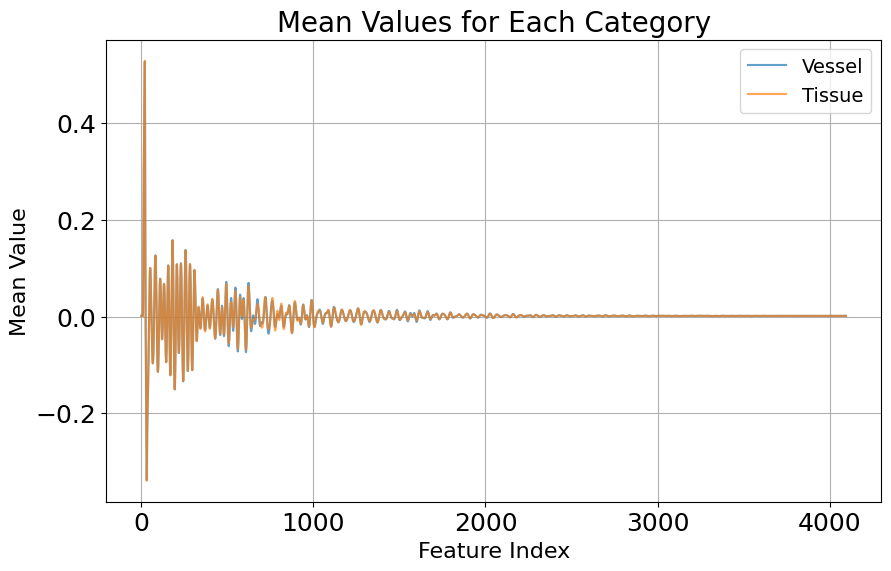

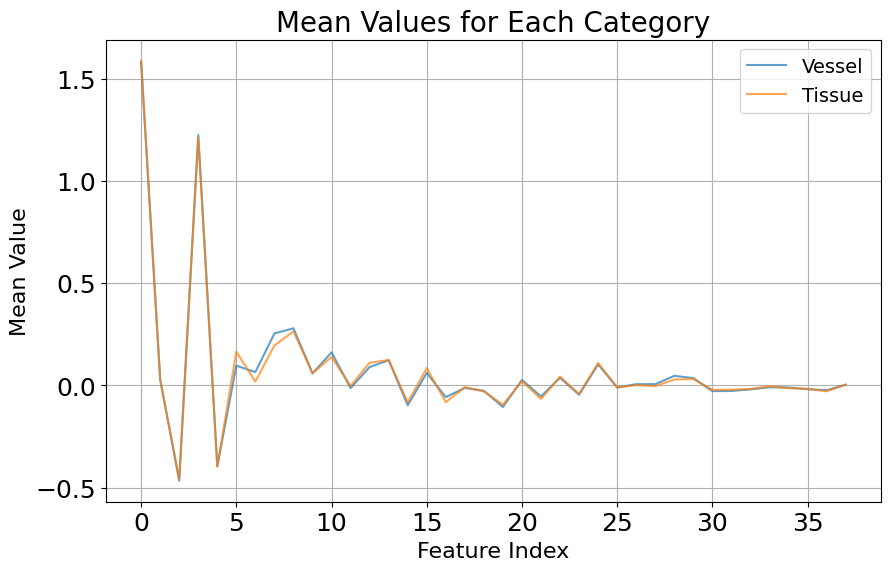

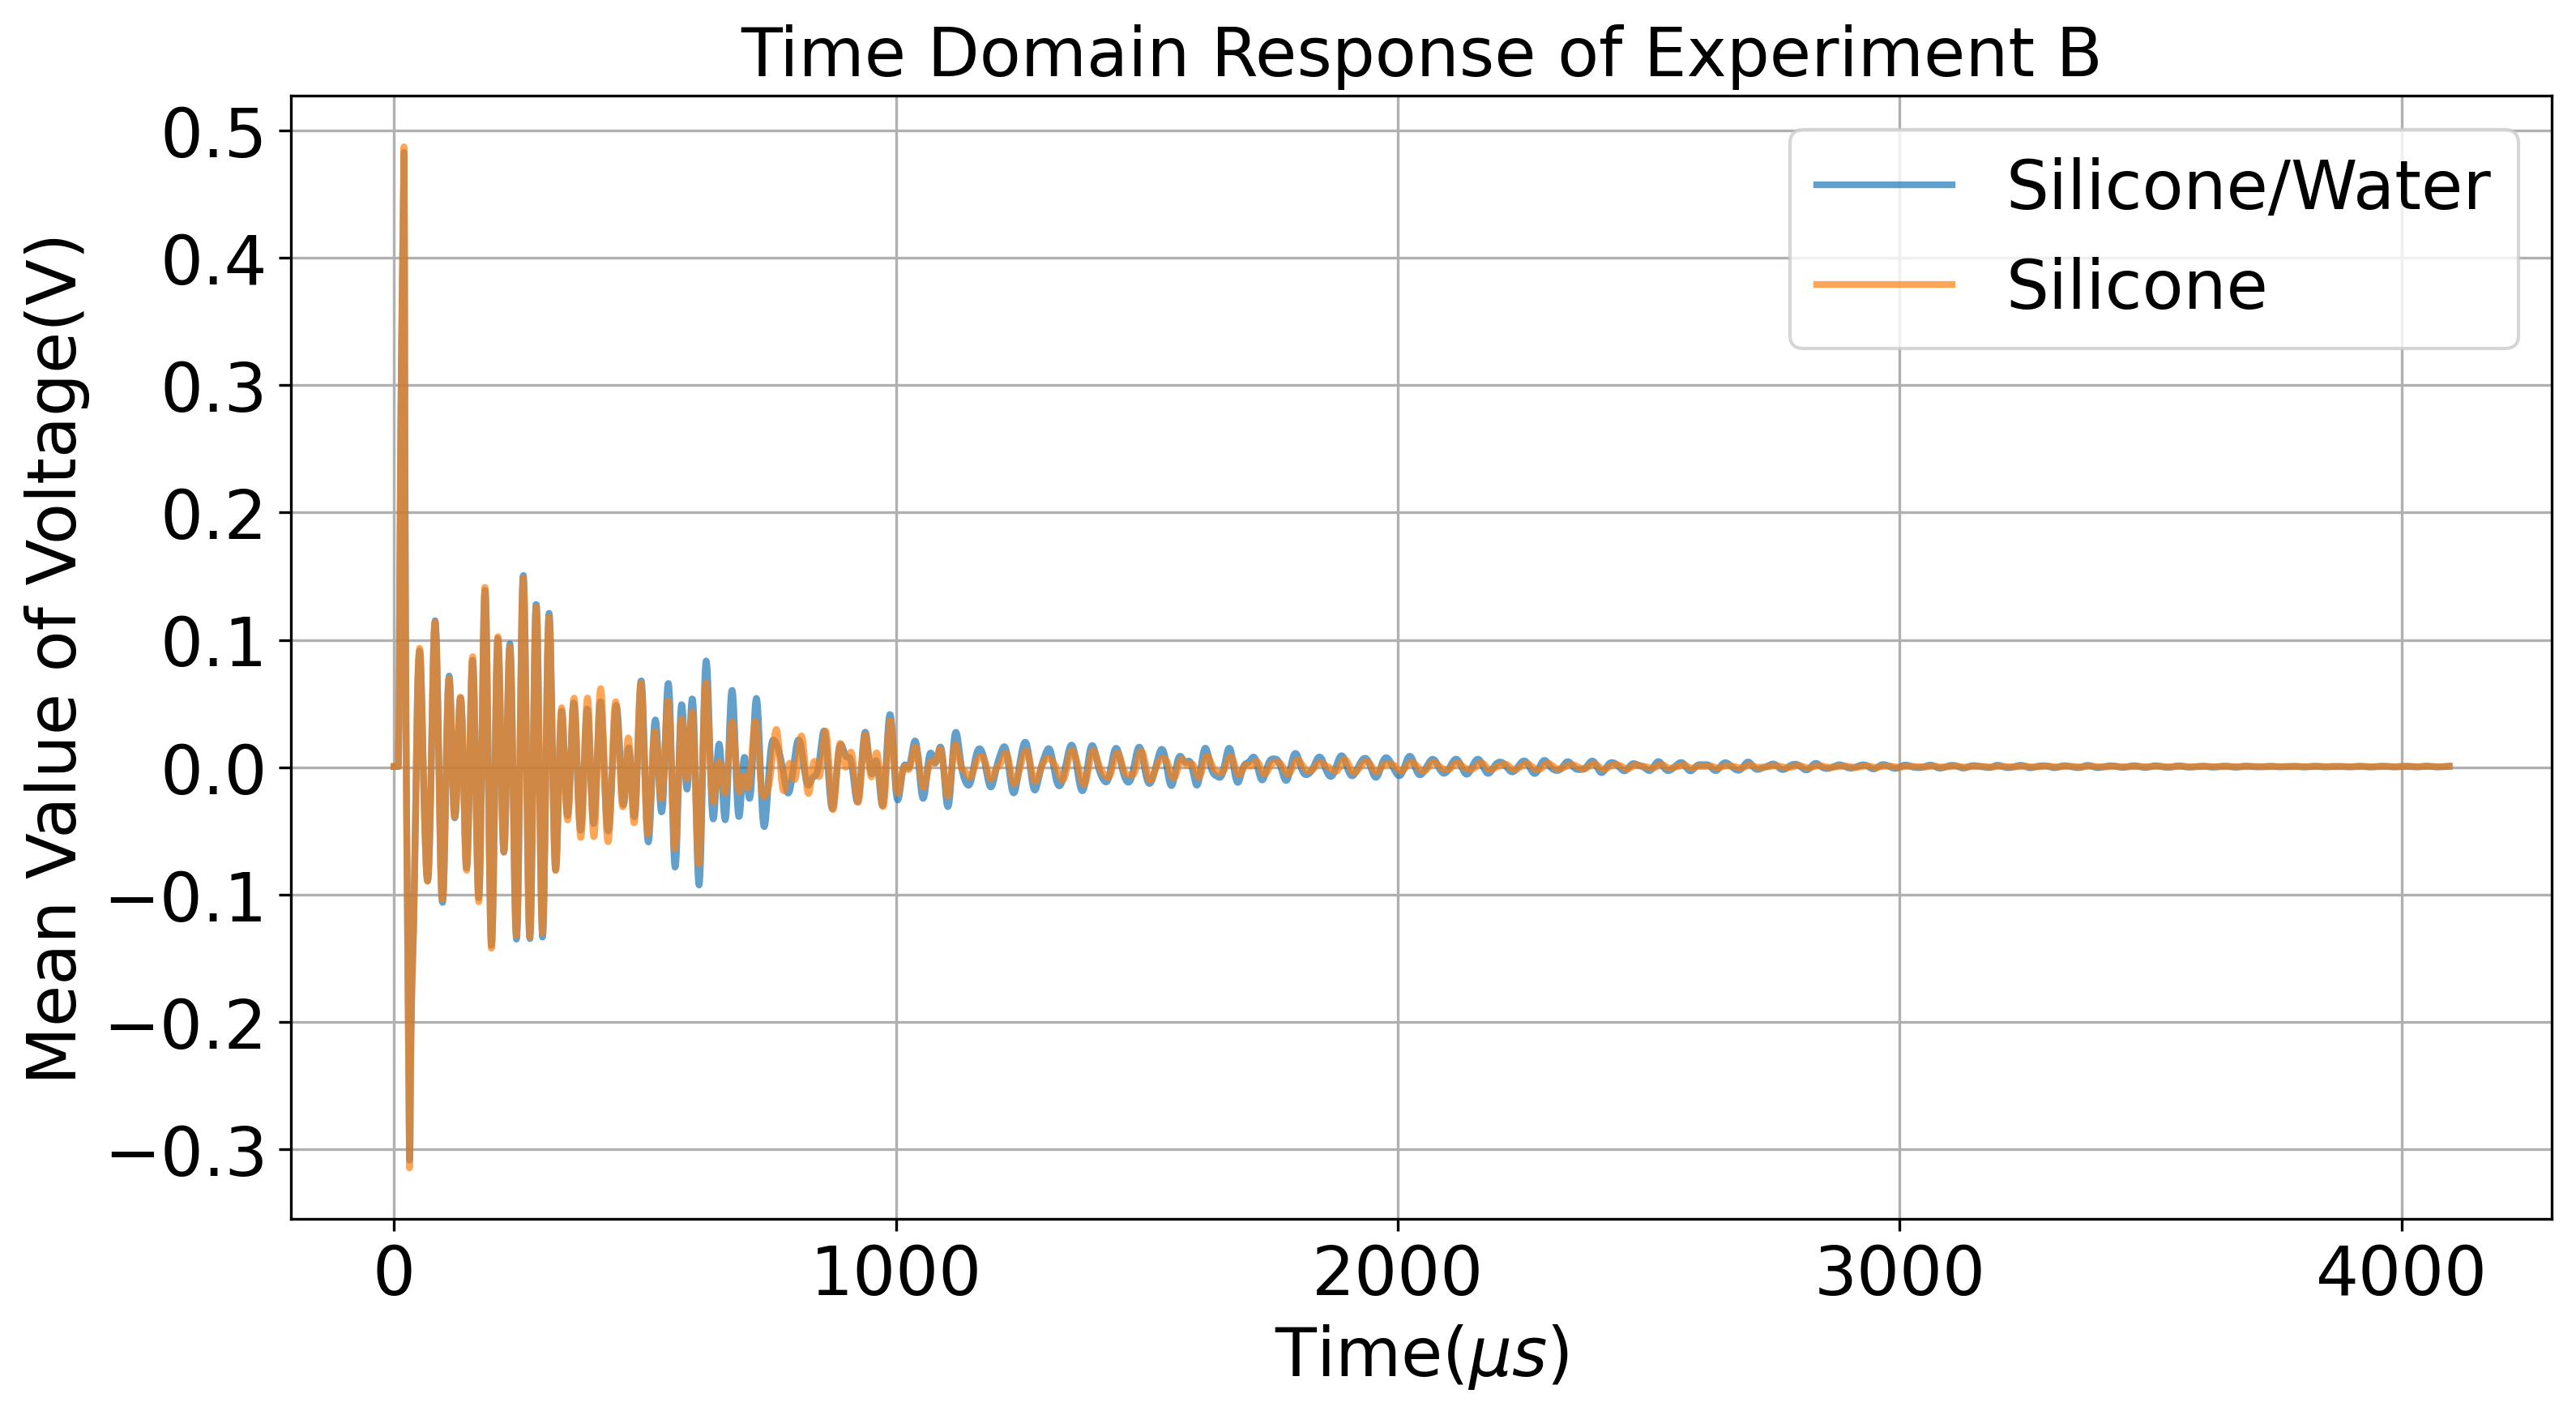

In [229]:
unique_labels = np.unique(y)
indices1 = {}
indices2 = {}
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = snapshot[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[i]}",alpha = 0.7)
# for i, value in enumerate(points):
#     if i == 0:
#         plt.axvline(x=value, color='red', linestyle='--', label='points')
#     else:
#         plt.axvline(x=value, color='red', linestyle='--')
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = Xredu[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6),dpi=300)
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_r.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = snapshot_r[indices2[materials[i]]].mean(axis=0) # type: ignore
        # 绘制均值曲线
    plt.plot(mean_values, label=f"{realmater[i]}",alpha = 0.7, linewidth = 2)
plt.xlabel("Time($\mu s$)",fontsize = 20)
plt.ylabel("Mean Value of Voltage(V)",fontsize = 20)
plt.title("Time Domain Response of Experiment B", fontsize=20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend(fontsize = 20)
plt.grid(True)
plt.show()

In [230]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [231]:
X_ver,X_te,y_ver,y_te = train_test_split(Xredu_r,y_r,test_size=0.7)
X_train, X_test, y_train, y_test = train_test_split(Xredu,y,test_size=0.01)

In [232]:
# Split data into train and test sets


# X_train = scale(Xp_train,axis=1)
# X_test = scale(Xp_test,axis=1)
# X_r_test = scale(Xp_r,axis=1)
scaler = StandardScaler()
# scaler = RobustScaler(unit_variance=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_te = scaler.transform(X_te)
X_ver = scaler.transform(X_ver)
# joblib.dump(scaler,'/Users/stonyxiong/files/Research/models/bloodmeat_time_scaler.save')


print(X_ver.shape)
print(X_te.shape)

(6000, 38)
(14000, 38)


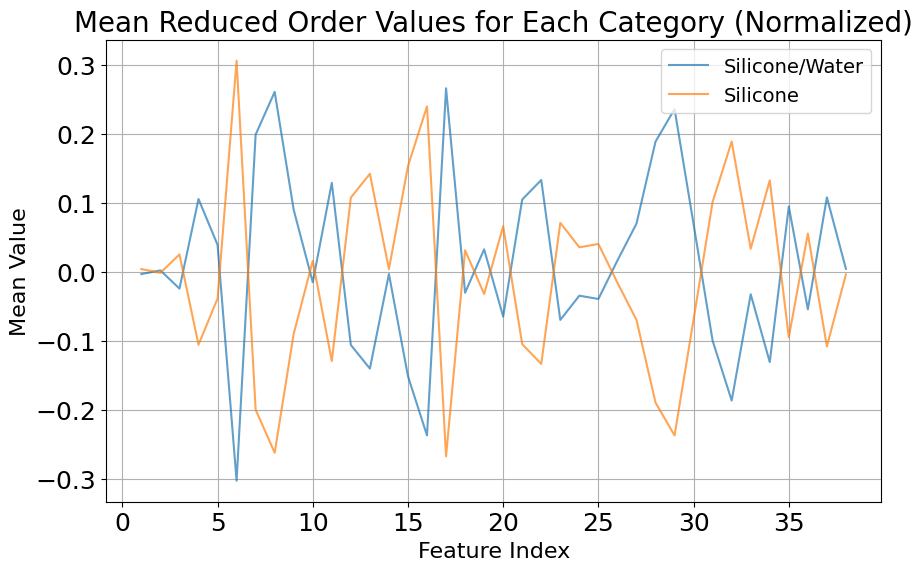

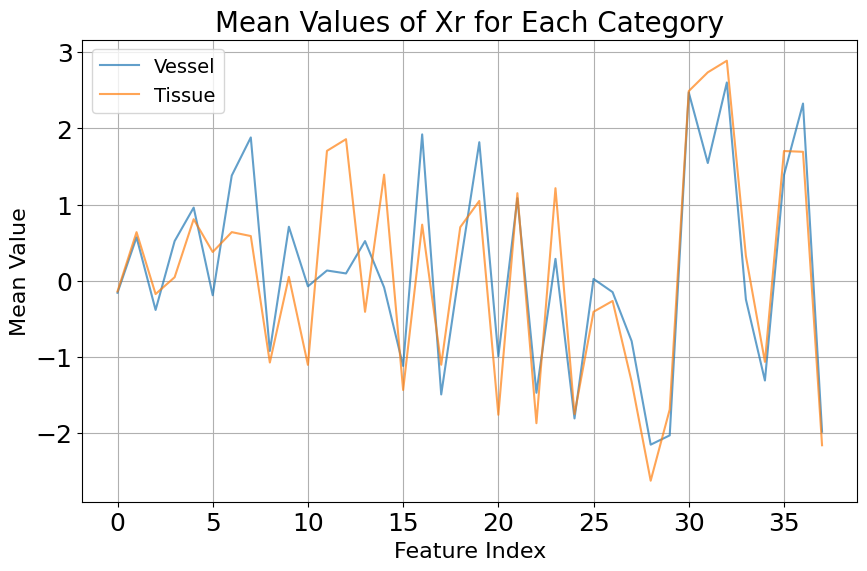

In [233]:
indices1 = {}
indices2 = {}
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(range(1, mean_values.shape[0] + 1), mean_values, label=f"{realmater[int(label)]}", alpha=0.7)
plt.xlabel("Feature Index")
# plt.xlim([1,36])
plt.ylabel("Mean Value")
plt.title("Mean Reduced Order Values for Each Category (Normalized)")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices2[materials[i]] = np.where(y_te.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_te[indices2[materials[i]]].mean(axis=0) # type: ignore
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[i]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values of Xr for Each Category")
plt.legend()
plt.grid(True)
plt.show()



In [234]:
class ANN_Model(nn.Module):
    def __init__(self, inputdim, hid1dim=24, hid2dim=26, p_drop=0.0, dropout=False):
        super().__init__()
        self.fc1 = nn.Linear(inputdim, hid1dim)
        self.fc2 = nn.Linear(hid1dim, hid2dim)
        self.fc3 = nn.Linear(hid2dim, hid1dim)
        self.head = nn.Linear(hid1dim, 2)
        self.act = nn.ELU()
        self.norm = nn.LayerNorm(hid1dim)   # 稳定训练（可选）
        self.drop = nn.Dropout(p_drop) if dropout else nn.Identity()

        with torch.no_grad():
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
            nn.init.xavier_uniform_(self.head.weight)
            self.fc3.weight.mul_(0.1)
            self.fc3.bias.zero_()
            self.head.bias.zero_()

    def forward(self, x):
        h1 = self.act(self.fc1(x))          # [B, hid1dim]
        h2 = self.act(self.fc2(h1))         # [B, hidmdim]
        h = self.fc3(h2)                   # [B, hid1dim]
        h3 = self.norm(h1 + h)              # 残差在同维度相加
        h3 = self.act(h3)
        h3 = self.drop(h3)
        o = self.head(h3)                    # [B, 2]
        return o
# class ANN_Model(nn.Module):
#     def __init__(self, inputdim, hid1dim=36, hid3dim=32, p_drop=0.2, dropout=False):
#         super().__init__()
#         self.fc1  = nn.Linear(inputdim, hid1dim)
#         self.fc2  = nn.Linear(hid1dim, inputdim)
#         self.fc3  = nn.Linear(inputdim, hid3dim)
#         self.head = nn.Linear(hid3dim, 2)
#         self.act  = nn.ELU()
#         self.norm = nn.LayerNorm(hid3dim)
#         self.drop = nn.Dropout(p_drop) if dropout else nn.Identity()

#         with torch.no_grad():
#             nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
#             nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
#             nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
#             nn.init.xavier_uniform_(self.head.weight)
#             self.fc2.weight.mul_(0.1)
#             self.head.bias.zero_()

#     def forward(self, x):
#         h1 = self.act(self.fc1(x))      # [B, hid1dim]
#         back = self.fc2(h1)             # [B, inputdim]
#         # h2 = self.norm(x + back)        # 残差 + LN
#         h2 = self.act(x + back)
#         h3 = self.norm(self.fc3(h2))
#         h3 = self.act(h3)     # [B, hid3dim]
#         h3 = self.drop(h3)
#         o  = self.head(h3)              # [B, 2] logits
#         return o
set_seed(42)

In [235]:
model = ANN_Model(X_train.shape[1]).to(device)

class_weights,_ = rebalance_weight(y_train)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
# 4. 将 numpy 数据转为 torch 张量并移动到 device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).squeeze().to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).squeeze().to(device)
X_ver_tensor = torch.tensor(X_ver, dtype=torch.float32).to(device)
y_ver_tensor = torch.tensor(y_ver,dtype=torch.long).squeeze().to(device)
X_te_tensor = torch.tensor(X_te, dtype = torch.float32).to(device)
y_te_tensor = torch.tensor(y_te,dtype=torch.long).squeeze().to(device)

In [ ]:
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# verify_dataset = TensorDataset(X_r_ver_tensor, y_r_ver_tensor)

# train_loader  = DataLoader(train_dataset, batch_size=8000, shuffle=True)
# verify_loader = DataLoader(verify_dataset, batch_size=2000, shuffle=False)

# num_epochs = 2000
# train_losses = []
# verify_losses = []

# pbar = tqdm(range(int(num_epochs)), desc="Training", leave=True)

# for epoch in pbar:
#     model.train()
#     for batch_X, batch_y in train_loader:
#         optimizer.zero_grad()
#         outputs = model(batch_X)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
#     train_losses.append(loss.item())
#     # —— 2. 验证 —— #
#     model.eval()
#     with torch.no_grad():
#         for batch_X, batch_y in verify_loader:
#             verify_outputs = model(batch_X)
#         verify_loss = criterion(verify_outputs, batch_y)
#         verify_losses.append(verify_loss.item())
#     # —— 3. 更新 tqdm 的显示 —— #
#     pbar.set_postfix(train_loss=loss.item(), verify_loss=verify_loss.item())

# 5. 训练模型
num_epochs = 51600
train_losses = []
verify_losses = []

pbar = tqdm(range(int(num_epochs)), desc="Training", leave=True)
for epoch in pbar:
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # —— 2. 验证 —— #
    model.eval()
    with torch.no_grad():
        verify_outputs = model(X_ver_tensor)
        verify_loss = criterion(verify_outputs, y_ver_tensor)
        verify_losses.append(verify_loss.item())
    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(train_loss=loss.item(), verify_loss=verify_loss.item())

Training:   0%|          | 0/52000 [00:00<?, ?it/s]

In [237]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_test, predicted_np)
    cm = confusion_matrix(y_test, predicted_np)

Accuracy: 0.9985714285714286
Accuracy_train: 0.999992784992785
Confusion Matrix:
[[716   0]
 [  2 682]]


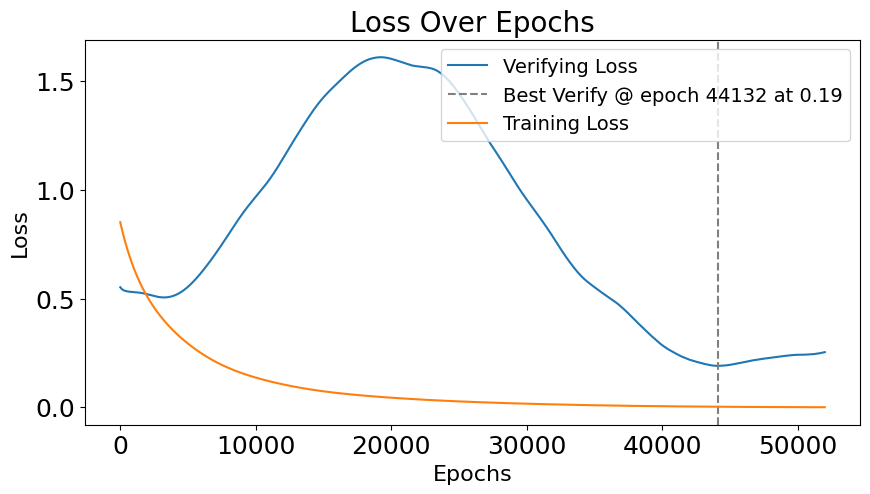

In [238]:
print(f'Accuracy: {accuracy}')
print(f'Accuracy_train: {accuracy_train}')
print(f'Confusion Matrix:\n{cm}')

plt_loss(train_losses=train_losses, verifying_losses =verify_losses)

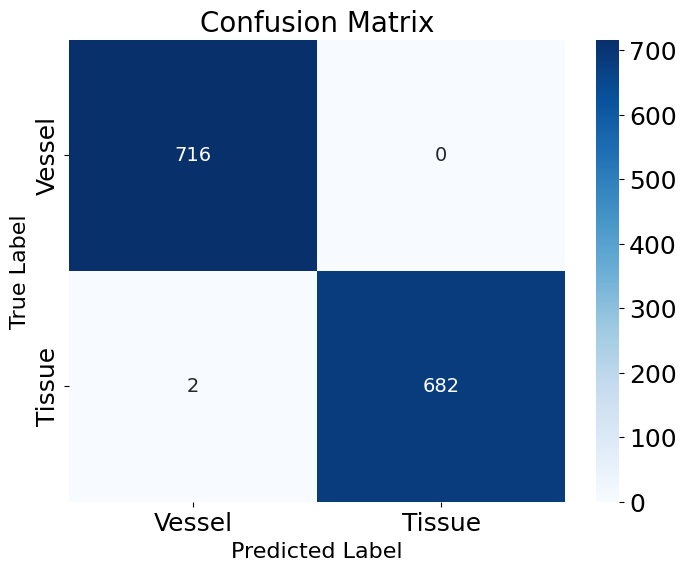

Accuracy: 0.9985714285714286
              precision    recall  f1-score   support

      Vessel       1.00      1.00      1.00       716
      Tissue       1.00      1.00      1.00       684

    accuracy                           1.00      1400
   macro avg       1.00      1.00      1.00      1400
weighted avg       1.00      1.00      1.00      1400



In [239]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=materials,
            yticklabels=materials)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

# Convert y_test to integer labels
y_test_int = y_test.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np,
                               target_names=materials, labels=range(len(materials)))
print("Accuracy:", accuracy)
print(report)

In [240]:
model.eval()
with torch.no_grad():
    r_te_outputs = model(X_te_tensor)
    _, predicted = torch.max(r_te_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    r_accuracy = accuracy_score(y_te, predicted_np)
    r_cm = confusion_matrix(y_te, predicted_np)

Accuracy: 0.9624285714285714


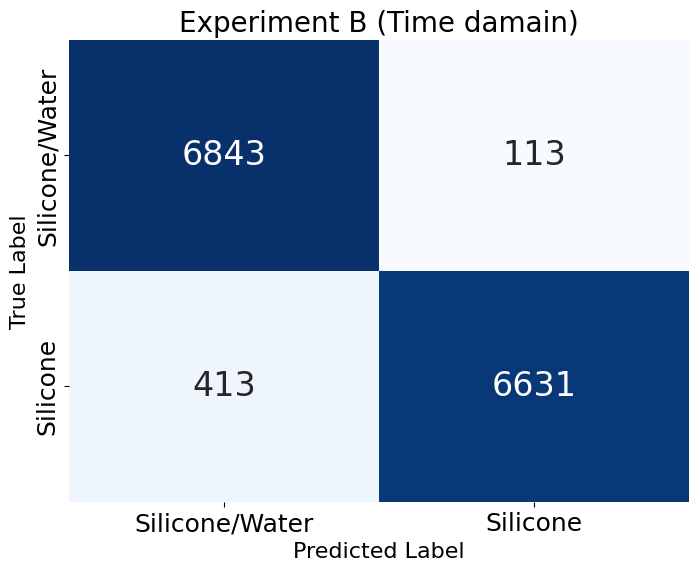

In [241]:
print(f'Accuracy: {r_accuracy}')
plt.figure(figsize=(8,6))
sns.heatmap(
    r_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=realmater,
    yticklabels=realmater,
    annot_kws={"size": 24}  # 设置数字字体大小
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Experiment B (Time damain)")
plt.xticks()
plt.yticks()
# plt.savefig("/Users/stonyxiong/files/Research/figures/ExpB-time.pdf", format="pdf", bbox_inches="tight")
plt.show()


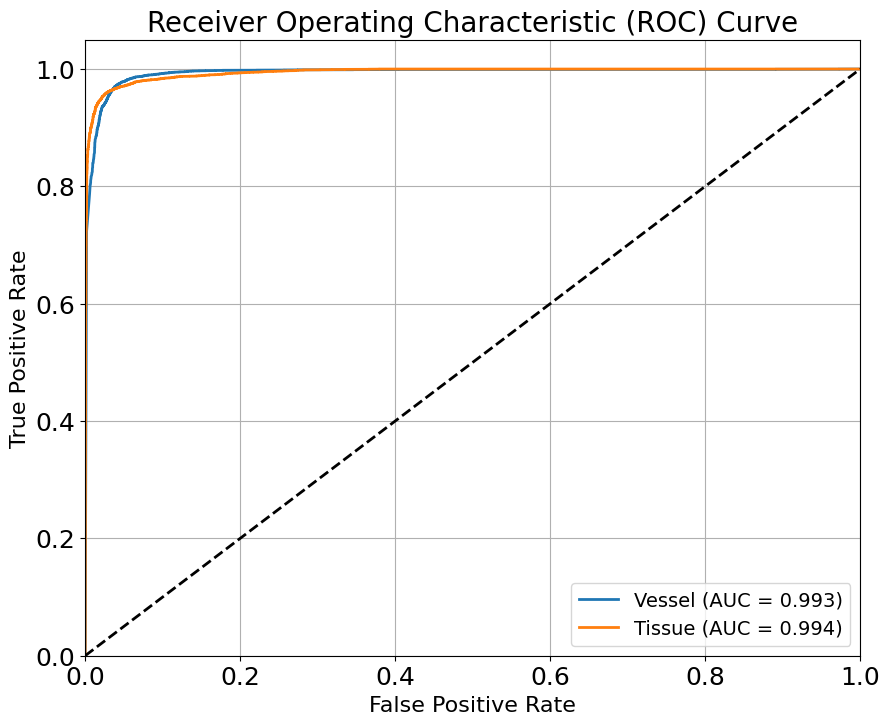

In [242]:
model.eval()
with torch.no_grad():
    logits = model(X_te_tensor.to(device))    # [N,2]
    
    # 方法 A：用 softmax 概率
    probs = torch.softmax(logits, dim=1)           # [N, 2]
    all_scores = probs[:, 1].cpu().numpy()         # 正类概率 ∈ [0,1]
    all_labels = y_te  # shape (N,)

# One-vs-rest approach for ROC curves
n_classes = len(materials)  # 3 classes: oil, water, vinegar
fpr = {}
tpr = {}
roc_auc = {}

# Get prediction probabilities for each class
probs_np = probs.cpu().numpy()

# Calculate ROC curve and ROC area for each class
for i, class_name in enumerate(materials):
	# Convert to binary classification: current class vs rest
	y_binary = (y_te.flatten() == i).astype(int)
	fpr[class_name], tpr[class_name], _ = roc_curve(y_binary, probs_np[:, i])
	roc_auc[class_name] = roc_auc_score(y_binary, probs_np[:, i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for class_name in materials:
	plt.plot(fpr[class_name], tpr[class_name], lw=2,
			 label=f'{class_name} (AUC = {roc_auc[class_name]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()